# Simulations of the N-body problem
We choose a fast numerical integrator to generate a simulation of our data

The following code integrates the pde over 12000 time steps

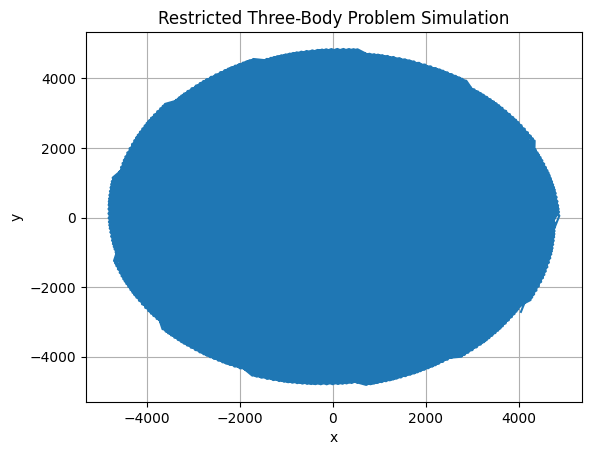

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the differential equations for the RTBP
def rtbp_equations(t, state, mu):
    x, y, vx, vy = state
    r1 = np.sqrt((x + mu)**2 + y**2)
    r2 = np.sqrt((x - 1 + mu)**2 + y**2)
    ax = 2*vy + x - (1-mu)*(x+mu)/(r1**3) - mu*(x-1+mu)/(r2**3)
    ay = -2*vx + y - (1-mu)*y/(r1**3) - mu*y/(r2**3)
    return [vx, vy, ax, ay]

# Mass ratio of the two primary bodies
mu = 0.1  # Example value

# Initial conditions: [x0, y0, vx0, vy0]
initial_state = [0.5, 0, 0, 1.5]

# Time span for the simulation
t_span = (0, 12000)

# Solve the RTBP equations
solution = solve_ivp(rtbp_equations, t_span, initial_state, args=(mu,), dense_output=True)

# Plot the solution

# To set the limits for the axes to zoom in:

#Let's call our dataset X
X = solution.y

plt.plot(solution.y[0], solution.y[1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Restricted Three-Body Problem Simulation')


plt.grid(True)
plt.show()


In [ ]:
print("Our dataset is of length" ,len(X)," by ", len(X[0]))

Our dataset is of length 4  by  12401


# Maybe we want to plot Hill's configuration

# What is Hill's Configuration?


![types of orbits](https://drive.google.com/file/d/1n1xvA1XOFFOtmZW7U3HBNv6EZUxGDLUn/view?usp=drive_link)

In these diagrams, the various colors represent different categories or types of orbits:

Escaping: Orbits leading to the test body escaping the gravitational influence of the primary bodies.

Crash 1 and Crash 2: Orbits that result in a collision with one of the two primary bodies.

Type 1a, Type 1b, Type 2a, etc.: These typically represent various stable or periodic orbits, quasi-periodic orbits, or other complex orbits. Each "type" might denote a specific kind of motion characterized by its geometry, stability, and temporal properties.

#The Architecture for the Autoencoder

We use an autoencoder to estimate the koopman operator and estimate the data over several time steps.

The architecture details for the autoencoder can be found in the paper:
 https://arxiv.org/pdf/2003.02236.pdf

TODO : Include details about its components

Code was adapted from the repository: https://github.com/erichson/koopmanAE


In [ ]:
from torch import nn
import torch

def gaussian_init_(n_units, std=1):
    sampler = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([std/n_units]))
    Omega = sampler.sample((n_units, n_units))[..., 0]
    return Omega


class encoderNet(nn.Module):
    def __init__(self, m, n, b, ALPHA = 1):
        super(encoderNet, self).__init__()
        self.N = m * n
        self.tanh = nn.Tanh()

        self.fc1 = nn.Linear(self.N, 16*ALPHA)
        self.fc2 = nn.Linear(16*ALPHA, 16*ALPHA)
        self.fc3 = nn.Linear(16*ALPHA, b)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = x.view(-1, 1, self.N)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)

        return x


class decoderNet(nn.Module):
    def __init__(self, m, n, b, ALPHA = 1):
        super(decoderNet, self).__init__()

        self.m = m
        self.n = n
        self.b = b

        self.tanh = nn.Tanh()

        self.fc1 = nn.Linear(b, 16*ALPHA)
        self.fc2 = nn.Linear(16*ALPHA, 16*ALPHA)
        self.fc3 = nn.Linear(16*ALPHA, m*n)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = x.view(-1, 1, self.b)
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = x.view(-1, 1, self.m, self.n)
        return x



class dynamics(nn.Module):
    def __init__(self, b, init_scale):
        super(dynamics, self).__init__()
        self.dynamics = nn.Linear(b, b, bias=False)
        self.dynamics.weight.data = gaussian_init_(b, std=1)
        U, _, V = torch.svd(self.dynamics.weight.data)
        self.dynamics.weight.data = torch.mm(U, V.t()) * init_scale


    def forward(self, x):
        x = self.dynamics(x)
        return x


class dynamics_back(nn.Module):
    def __init__(self, b, omega):
        super(dynamics_back, self).__init__()
        self.dynamics = nn.Linear(b, b, bias=False)
        self.dynamics.weight.data = torch.pinverse(omega.dynamics.weight.data.t())

    def forward(self, x):
        x = self.dynamics(x)
        return x


class koopmanAE(nn.Module):
    def __init__(self, m, n, b, steps, steps_back, alpha = 1, init_scale=1):
        super(koopmanAE, self).__init__()
        self.steps = steps
        self.steps_back = steps_back

        self.encoder = encoderNet(m, n, b, ALPHA = alpha)
        self.dynamics = dynamics(b, init_scale)
        self.backdynamics = dynamics_back(b, self.dynamics)
        self.decoder = decoderNet(m, n, b, ALPHA = alpha)


    def forward(self, x, mode='forward'):
        out = []
        out_back = []
        z = self.encoder(x.contiguous())
        q = z.contiguous()


        if mode == 'forward':
            for _ in range(self.steps):
                q = self.dynamics(q)
                out.append(self.decoder(q))

            out.append(self.decoder(z.contiguous()))
            return out, out_back

        if mode == 'backward':
            for _ in range(self.steps_back):
                q = self.backdynamics(q)
                out_back.append(self.decoder(q))

            out_back.append(self.decoder(z.contiguous()))
            return out, out_back

# Data Preprocessing before we feed the data to the autoencoder
Mapping the data into a higher dimensional space by a random orthogonal projection: embedding (?)
We need to add some noise to the dataset: figure out the purpose of this (how helpful can that be)

In [ ]:
Xclean = X.copy()
X += np.random.standard_normal(X.shape)

#maybe we need to add some noise to the dataset (figure out its importance and why do we need to do so)


# Rotate to high-dimensional space
Q = np.random.standard_normal((64,4))
Q,_ = np.linalg.qr(Q)

X = X.T.dot(Q.T) # rotate
print(X.shape)
Xclean = Xclean.T.dot(Q.T)
print(Xclean.shape)

# scale
X = 2 * (X - np.min(X)) / np.ptp(X) - 1
Xclean = 2 * (Xclean - np.min(Xclean)) / np.ptp(Xclean) - 1


# split into train and test set
X_train = X[0:6000]
X_test = X[6000:12001]

X_train_clean = Xclean[0:6000]
X_test_clean = Xclean[6000:12001]

(12401, 64)
(12401, 64)


In [ ]:
print(X_train.shape, X_test.shape)

(600, 64) (600, 64)


# Defining the training method

TODO:Need to figure out how to save model and also error rate, predictions, etc

In [ ]:
import torch
import torchvision
from torch import nn
from torch import autograd
from torch import optim
from torchvision import transforms, datasets
from torch.autograd import grad
from timeit import default_timer as timer

import matplotlib.pyplot as plt

import numpy as np


import torch.nn.init as init

def set_seed(seed=0):
    """Set one seed for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)

def get_device():
    """Get a gpu if available."""
    if torch.cuda.device_count()>0:
        device = torch.device('cuda')
        print("Connected to a GPU")
    else:
        print("Using the CPU")
        device = torch.device('cpu')
    return device


def add_channels(X):
    if len(X.shape) == 2:
        return X.reshape(X.shape[0], 1, X.shape[1],1)

    elif len(X.shape) == 3:
        return X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])

    else:
        return "dimenional error"


def weights_init(m):
    if isinstance(m, nn.Linear):
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)

In [ ]:
import torch
from torch import nn
import numpy as np




def train(model, train_loader, lr, weight_decay,
          lamb, num_epochs, learning_rate_change, epoch_update,
          nu=0.0, eta=0.0, backward=0, steps=1, steps_back=1, gradclip=1):

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    device = get_device()


    def lr_scheduler(optimizer, epoch, lr_decay_rate=0.8, decayEpoch=[]):
                    """Decay learning rate by a factor of lr_decay_rate every lr_decay_epoch epochs"""
                    if epoch in decayEpoch:
                        for param_group in optimizer.param_groups:
                            param_group['lr'] *= lr_decay_rate
                        return optimizer
                    else:
                        return optimizer




    criterion = nn.MSELoss().to(device)


    epoch_hist = []
    loss_hist = []
    epoch_loss = []

    for epoch in range(num_epochs):
        #print(epoch)
        for batch_idx, data_list in enumerate(train_loader):
            model.train()
            out, out_back = model(data_list[0].to(device), mode='forward')


            for k in range(steps):
                if k == 0:
                    loss_fwd = criterion(out[k], data_list[k+1].to(device))
                else:
                    loss_fwd += criterion(out[k], data_list[k+1].to(device))


            loss_identity = criterion(out[-1], data_list[0].to(device)) * steps


            loss_bwd = 0.0
            loss_consist = 0.0

            loss_bwd = 0.0
            loss_consist = 0.0

            if backward == 1:
                out, out_back = model(data_list[-1].to(device), mode='backward')


                for k in range(steps_back):

                    if k == 0:
                        loss_bwd = criterion(out_back[k], data_list[::-1][k+1].to(device))
                    else:
                        loss_bwd += criterion(out_back[k], data_list[::-1][k+1].to(device))


                A = model.dynamics.dynamics.weight
                B = model.backdynamics.dynamics.weight

                K = A.shape[-1]

                for k in range(1,K+1):
                    As1 = A[:,:k]
                    Bs1 = B[:k,:]
                    As2 = A[:k,:]
                    Bs2 = B[:,:k]

                    Ik = torch.eye(k).float().to(device)

                    if k == 1:
                        loss_consist = (torch.sum((torch.mm(Bs1, As1) - Ik)**2) + \
                                         torch.sum((torch.mm(As2, Bs2) - Ik)**2) ) / (2.0*k)
                    else:
                        loss_consist += (torch.sum((torch.mm(Bs1, As1) - Ik)**2) + \
                                         torch.sum((torch.mm(As2, Bs2)-  Ik)**2) ) / (2.0*k)





#                Ik = torch.eye(K).float().to(device)
#                loss_consist = (torch.sum( (torch.mm(A, B)-Ik )**2)**1 + \
#                                         torch.sum( (torch.mm(B, A)-Ik)**2)**1 )
#



            loss = loss_fwd + lamb * loss_identity +  nu * loss_bwd + eta * loss_consist

            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradclip) # gradient clip
            optimizer.step()

        # schedule learning rate decay
        lr_scheduler(optimizer, epoch, lr_decay_rate=learning_rate_change, decayEpoch=epoch_update)
        loss_hist.append(loss)
        epoch_loss.append(epoch)


        if (epoch) % 20 == 0:
                print('********** Epoche %s **********' %(epoch+1))

                print("loss identity: ", loss_identity.item())
                if backward == 1:
                    print("loss backward: ", loss_bwd.item())
                    print("loss consistent: ", loss_consist.item())
                print("loss forward: ", loss_fwd.item())
                print("loss sum: ", loss.item())

                epoch_hist.append(epoch+1)

                if hasattr(model.dynamics, 'dynamics'):
                    w, _ = np.linalg.eig(model.dynamics.dynamics.weight.data.cpu().numpy())
                    print(np.abs(w))


    if backward == 1:
        loss_consist = loss_consist.item()


    return model, optimizer, [epoch_hist, loss_fwd.item(), loss_consist]

# We start a training run

TODO:


*   Figure out how to choose hyperparameters during training
*   Maybe generate a plot of hyperparameters during training and how do they affect loss



In [ ]:
from torch.utils.data import DataLoader, Dataset

import torch.nn.init as init


# Reshape data for pytorch into 4D tensor Samples x Channels x Width x Hight
#******************************************************************************
Xtrain = add_channels(X_train)
Xtest = add_channels(X_test)

# transfer to tensor
Xtrain = torch.from_numpy(Xtrain).float().contiguous()
Xtest = torch.from_numpy(Xtest).float().contiguous()

#******************************************************************************
# Reshape data for pytorch into 4D tensor Samples x Channels x Width x Hight
#******************************************************************************
Xtrain_clean = add_channels(X_train_clean)
Xtest_clean = add_channels(X_test_clean)

# transfer to tensor
Xtrain_clean = torch.from_numpy(Xtrain_clean).float().contiguous()
Xtest_clean = torch.from_numpy(Xtest_clean).float().contiguous()

#Declaring some hyperparameters - default values
lamb = 1
steps = 8
lr =1e-2
bottleneck= 6
lr_update = [30, 200, 400, 500],
epochs = 600
batch = 64
steps_back = 8
wd = 0
lr_decay = 0.2
nu =1e-1
eta = 1e-2
backward = 0
gradclip = 0.05
pred_steps = 1000
m = 64
n= 1
#******************************************************************************
# Create Dataloader objects
#******************************************************************************
trainDat = []
start = 0
for i in np.arange(steps,-1, -1):
    if i == 0:
        trainDat.append(Xtrain[start:].float())
    else:
        trainDat.append(Xtrain[start:-i].float())
    start += 1

train_data = torch.utils.data.TensorDataset(*trainDat)
del(trainDat)



train_loader = DataLoader(dataset = train_data,
                              batch_size = batch,
                              shuffle = True)

#==============================================================================
# Model
#==============================================================================
print(Xtrain.shape)
model = koopmanAE(m, n, bottleneck, steps, steps_back)
print('koopmanAE')
#model = torch.nn.DataParallel(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)


#==============================================================================
# Model summary
#==============================================================================
print('**** Setup ****')
print('Total params: %.2fM' % (sum(p.numel() for p in model.parameters())/1000000.0))
print('Total params: %.2fk' % (sum(p.numel() for p in model.parameters())/1000.0))
print('************')
print(model)


#==============================================================================
# Start training
#==============================================================================
model, optimizer, epoch_hist = train(model, train_loader,
                    lr=lr, weight_decay=wd, lamb=lamb, num_epochs =epochs,
                    learning_rate_change=lr_decay, epoch_update=lr_update,
                    nu = nu, eta = eta, backward=backward, steps=steps, steps_back=steps_back,
                    gradclip=gradclip)


#torch.save(model.state_dict(), args.folder + '/model'+'.pkl')


#******************************************************************************
# Prediction
#******************************************************************************
Xinput, Xtarget = Xtest[:-1], Xtest[1:]
_, Xtarget = Xtest_clean[:-1], Xtest_clean[1:]


snapshots_pred = []
snapshots_truth = []


error = []
for i in range(30):
            error_temp = []
            init = Xinput[i].float().to(device)
            if i == 0:
                init0 = init

            z = model.encoder(init) # embedd data in latent space

            for j in range(pred_steps):
                if isinstance(z, tuple):
                    z = model.dynamics(*z) # evolve system in time
                else:
                    z = model.dynamics(z)
                if isinstance(z, tuple):
                    x_pred = model.decoder(z[0])
                else:
                    x_pred = model.decoder(z) # map back to high-dimensional space
                #print("X target shape and index we are trying to access",Xtarget.shape, i+j)

                if i+ j < 6000:
                  target_temp = Xtarget[i+j].data.cpu().numpy().reshape(m,n)
                  error_temp.append(np.linalg.norm(x_pred.data.cpu().numpy().reshape(m,n) - target_temp) / np.linalg.norm(target_temp))
                if i+ j == 6001:
                  error_temp.append(np.linalg.norm(x_pred.data.cpu().numpy().reshape(m,n) - target_temp) / np.linalg.norm(target_temp))

                if i == 0:
                    snapshots_pred.append(x_pred.data.cpu().numpy().reshape(m,n))
                    snapshots_truth.append(target_temp)

            error.append(np.asarray(error_temp))





torch.Size([6000, 1, 64, 1])
koopmanAE
**** Setup ****
Total params: 0.00M
Total params: 2.96k
************
koopmanAE(
  (encoder): encoderNet(
    (tanh): Tanh()
    (fc1): Linear(in_features=64, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=6, bias=True)
  )
  (dynamics): dynamics(
    (dynamics): Linear(in_features=6, out_features=6, bias=False)
  )
  (backdynamics): dynamics_back(
    (dynamics): Linear(in_features=6, out_features=6, bias=False)
  )
  (decoder): decoderNet(
    (tanh): Tanh()
    (fc1): Linear(in_features=6, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=64, bias=True)
  )
)
Connected to a GPU
********** Epoche 1 **********
loss identity:  0.0003201182989869267
loss forward:  0.0003940986644010991
loss sum:  0.0007142169633880258
[0.75829417 0.75829417 0.9992381  0.9992381  0.8555493  0.

Error measures approximately how far away the vector we predicted is from the vector we calculated:
Here is the formula:

error = np.linalg.norm(x_pred.data.cpu().numpy().reshape(m,n) - target_temp) / np.linalg.norm(target_temp))

In [ ]:
error

[array([0.03827856, 0.03253082, 0.04078572, 0.045335  , 0.04382428,
        0.04800588, 0.03375627, 0.03247804, 0.0417489 , 0.03136922,
        0.04965458, 0.057388  , 0.03461547, 0.03218504, 0.02931855,
        0.03550057, 0.04005162, 0.03946394, 0.04119177, 0.03155638,
        0.02862437, 0.03702967, 0.0271369 , 0.04544073, 0.05084294,
        0.0266802 , 0.02579619, 0.02571404, 0.03139165, 0.03390159,
        0.03556681, 0.03511358, 0.02884866, 0.02536969, 0.032324  ,
        0.02347766, 0.04180347, 0.04414147, 0.0192775 , 0.02141499,
        0.02270668, 0.02806738, 0.02893626, 0.03289055, 0.03048552,
        0.02823974, 0.02254143, 0.02785521, 0.0196018 , 0.0374956 ,
        0.03911347, 0.01461244, 0.01917167, 0.01956514, 0.02385499,
        0.02483913, 0.02976308, 0.02606674, 0.03161741, 0.02022283,
        0.02396419, 0.01508314, 0.03159072, 0.03723961, 0.01480462,
        0.01670432, 0.0162933 , 0.01722809, 0.02072176, 0.02471899,
        0.02021203, 0.03322564, 0.01980363, 0.01

# Now we will explain the approximation done in each part of the Autoencoder.

The autoencoder has 3 subparts:


*   Encoder Net
*   Linear Dynamics
*   Decoder Net


Here are the matrices involved in the Encoder layer:
(Note that the encoder layer maps state variables to observables)

*   Encoder.fc1
*   Encoder.fc2
*   Encoder.fc3

So basically we do the following:

$$x = tan_h(fc_1(x) + b_1)$$

$$x = tan_h(fc_2(x) + b_2)$$

$$x = fc_3(x)$$

Let's see the sizes of fc1 , fc2 and fc3 respectively

In [ ]:
print(model.encoder.fc1.weight.shape)
print(model.encoder.fc2.weight.shape)
print(model.encoder.fc3.weight.shape)

torch.Size([16, 64])
torch.Size([16, 16])
torch.Size([6, 16])


Let's have a look at the linear dynamics
That is the koopman operator and the "backward" koopman operator

So the linear dynamics layer does the following simultaneously;
$x_{i + 1} = K(x_i)$ where K = dynamics

and the $x_{i} = K_{back}(x_{i +1})$ where $K_{back}$ = backward dynamics

Let's see the dimension of the matrices

In [ ]:
print(model.dynamics.dynamics.weight.shape)
print(model.backdynamics.dynamics.weight.shape)

torch.Size([6, 6])
torch.Size([6, 6])


Finally Let's have a look at the Decoder Layer:

Here are the matrices involved in the Decoder layer:
(Note that the encoder layer maps state variables to observables)

*   Decoder.fc1
*   Decoder.fc2
*   Decoder.fc3

So basically we do the following:

$$x = tan_h(fc_1(x) + b_1)$$

$$x = tan_h(fc_2(x) + b_2)$$

$$x = fc_3(x)$$

Let's see the sizes of fc1 , fc2 and fc3 respectively
Note: These matrices are not related to the matrices in the EncoderNet, but their dimension is similar to the traspose of the matrices in the EncoderNet

Let's have a look at their dimension.

In [ ]:
print(model.decoder.fc1.weight.shape)
print(model.decoder.fc2.weight.shape)
print(model.decoder.fc3.weight.shape)

torch.Size([16, 6])
torch.Size([16, 16])
torch.Size([64, 16])


# TODO: Let's generate some snapshots using our observable map and the koopman operator given by the parameter of the autoencoder we trained above

